# Xarray and netcdf4 for labeled multi-dimensional data 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import skimage
import os
import numpy as np

## Create a Xarray dataset and store as netcdf4 
Example: Time series of folders containing 2D-tiffs as moderate 4D tomography that still fits in RAM

In [2]:
toppath = '/data/visitor/ihma699/id19/20250713/PROCESSED_DATA/TOMCAT/XTM_processing/reconstructed_data/T3_025_3_III/00_raw'

In [3]:
raw_folders = os.listdir(toppath)
# clear weird entries in the folder and only keep data subfolders
folders = []
for folder in raw_folders:
    if folder[:6] == 'rec_16': #look for some reliable name pattern of the correct folders
        folders.append(folder)
folders.sort() # sort the folders in the list, esp. windows has weird sorting conventions by its own

In [4]:
def ReadStack(folder):
    files = os.listdir(folder) #folder containing only many 2D tiffs
    files.sort()
    testim = skimage.io.imread(os.path.join(folder, files[0]))
    shp = testim.shape
    Stack = np.zeros(shp+(len(files),), dtype=testim.dtype)
    for i in range(len(files)):
        Stack[:,:,i] = skimage.io.imread(os.path.join(folder, files[i]))
    return Stack

### figure out the dimensions of the 4D array and pre-allocate the memory

In [5]:
len_t = len(folders) #how many timesteps
zeroth_Stack = ReadStack(os.path.join(toppath, folders[0], folders[0])) # adapt os.path.jopin to your particular folder structure, here ../rec_16bit_phase_00001/rec_16bit_phase_00001/*.tiff

In [6]:
shp = (zeroth_Stack.shape)+(len_t,)
print('4D shape:',shp)
image_data = np.zeros(shp, dtype=zeroth_Stack.dtype)

4D shape: (240, 240, 2016, 361)


### Load 4D image data from thousands 2D tiffs, simple version

In [7]:
# populate the 4D array. It loads almost a million 2D tiffs, this takes while. Can be done in parallel to be faster, for example see joblib Parrallel
for i in range(len_t): # we load the first time step (zeroth_Stack) again, but in this case, this inefficiency is worth the cleaner code IMO
    if i%10==0: print(i,'/',len_t)
    Stackpath = os.path.join(toppath, folders[i], folders[i]) # adapt accordingly, see above
    image_data[:,:,:,i] = ReadStack(Stackpath)

### Load 4D image data from thousands 2D tiffs, embarrassingly parallel version
faster. but generous on RAM, needs double the size of the final array. bottleneck is then the disk reading speed. 2D tiffs are not ideal for 4D data

In [8]:
from joblib import Parallel, delayed

In [9]:
results = Parallel(n_jobs=64)(delayed(ReadStack)(os.path.join(toppath, folders[i], folders[i])) for i in range(len_t)) # the syntax is a bit uncommon, just remember it
for i in range(len_t):
    image_data[:,:,:,i] = results[i]
del results

### Try displaying a random slice

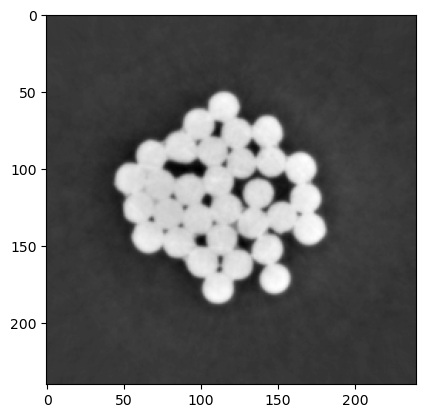

In [11]:
plt.imshow(image_data[:,:,500,10], cmap='gray')

### Put the 4D data into Xarray dataset

In [17]:
# create the coordinate arrays
px = 2.75E-6 # voxel size in m
vx = px**3 #voxel size in m3. I like to call the volume of a voxel vx, and the voxel edge length px

x = np.arange(image_data.shape[0])
y = np.arange(image_data.shape[1])
z = np.arange(image_data.shape[2])
ts = np.arange(image_data.shape[3])

# check the xarray documention for more details
im_data = xr.Dataset({'image_data': (['x','y','z','ts'], image_data),  # the data is a dictionary containing a tuple of coordinates and the array for each seperate datarray in the "dataset"
                     'x_meter': ('x', x*px),                    # can be multiple arrays, for example the coordinates in m
                     'y_meter': ('y', y*px),
                     'z_meter': ('z', z*px)
                     },
                     coords = {'x': x,
                               'y': y,
                               'z': z,
                               'ts': ts},                      #the real time can often be found in the raw projection data, omitted here
                     attrs = {'voxel size': '2.75um',          # attr (attributes) allows to store some additional metadata as str or value
                             'px':   2.75E-6,
                             'sample name': 'T3_025_3_III',
                             'processing stage': 'phase retrieval reconstruction'}
                    )
im_data['x_meter'].attrs['units'] = 'm'             #xarray has some useful pre-defined attrs for arrays and coordinates
im_data['y_meter'].attrs['units'] = 'm'
im_data['z_meter'].attrs['units'] = 'm'
im_data['x'].attrs['units'] = 'px'
im_data['y'].attrs['units'] = 'px'
im_data['z'].attrs['units'] = 'px'
im_data['ts'].attrs['units'] = 'time step'
im_data['image_data'].attrs['units'] = '16 bit'

In [18]:
im_data

<xarray.Dataset> Size: 84GB
Dimensions:     (x: 240, y: 240, z: 2016, ts: 361)
Coordinates:
  * x           (x) int64 2kB 0 1 2 3 4 5 6 7 ... 233 234 235 236 237 238 239
  * y           (y) int64 2kB 0 1 2 3 4 5 6 7 ... 233 234 235 236 237 238 239
  * z           (z) int64 16kB 0 1 2 3 4 5 6 ... 2010 2011 2012 2013 2014 2015
  * ts          (ts) int64 3kB 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360
Data variables:
    image_data  (x, y, z, ts) uint16 84GB 9455 8528 8596 ... 65535 65535 65535
    x_meter     (x) float64 2kB 0.0 2.75e-06 5.5e-06 ... 0.0006545 0.0006572
    y_meter     (y) float64 2kB 0.0 2.75e-06 5.5e-06 ... 0.0006545 0.0006572
    z_meter     (z) float64 16kB 0.0 2.75e-06 5.5e-06 ... 0.005539 0.005541
Attributes:
    voxel size:        2.75um
    px:                2.75e-06
    sample name:       T3_025_3_III
    processing stage:  phase retrieval reconstruction

### store the dataset as netcdf4, other options are for example zarr
there are some options to optimize the data structure on disk, but I have to learn them first

In [19]:
nc_outpath = '/data/visitor/ihma699/id19/20250713/PROCESSED_DATA/TOMCAT/XTM_processing/T3_025_3_III_reconstructions.nc'
im_data.to_netcdf(nc_outpath)

### test loading the 4D dataset and see how much faster it is

In [20]:
im_data = xr.load_dataset(nc_outpath)

## Inspect an existing netcdf4 of processed data

In [13]:
nc_path = '/data/visitor/ihma699/id19/20250713/PROCESSED_DATA/TOMCAT/XTM_processing/processed_data/T3_025_3_III/dyn_data_T3_025_3_III.nc'

In [14]:
data = xr.load_dataset(nc_path) # xr.open_dataset does lazy loading, preferable for large datafiles

In [16]:
data['filling'].attrs

{'units': 'voxel/s'}

(0.0, 1400.0)

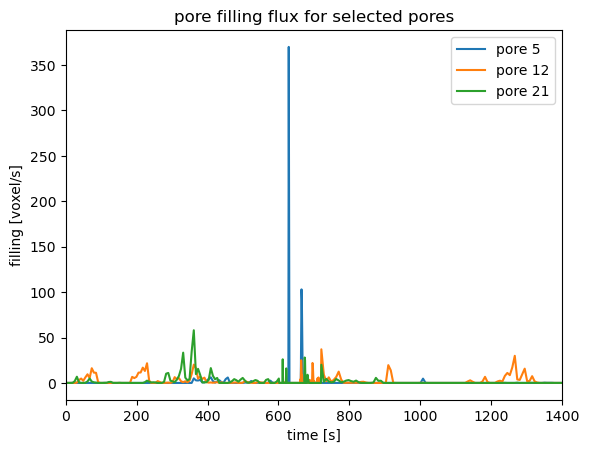

In [22]:
data['filling'].sel(label = 5).plot(label = 'pore 5')
data['filling'].sel(label = 12).plot(label = 'pore 12')
data['filling'].sel(label = 21).plot(label = 'pore 21')
plt.legend()
plt.title('pore filling flux for selected pores')
plt.xlim(0,1400)

(0.0, 1400.0)

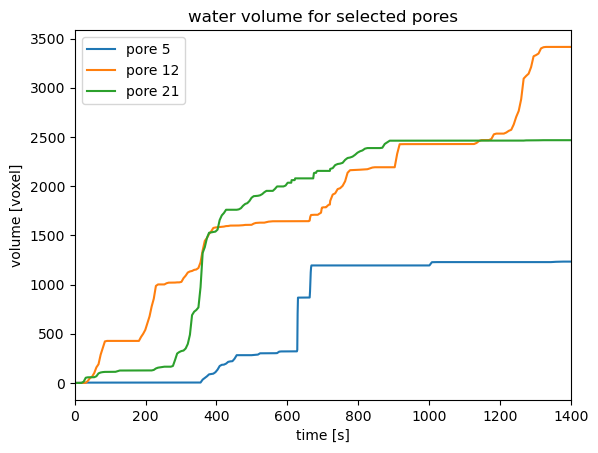

In [30]:
data['volume'].sel(label = 5).plot(label = 'pore 5')
data['volume'].sel(label = 12).plot(label = 'pore 12')
data['volume'].sel(label = 21).plot(label = 'pore 21')
plt.legend()
plt.title('water volume for selected pores')
plt.xlim(0,1400)

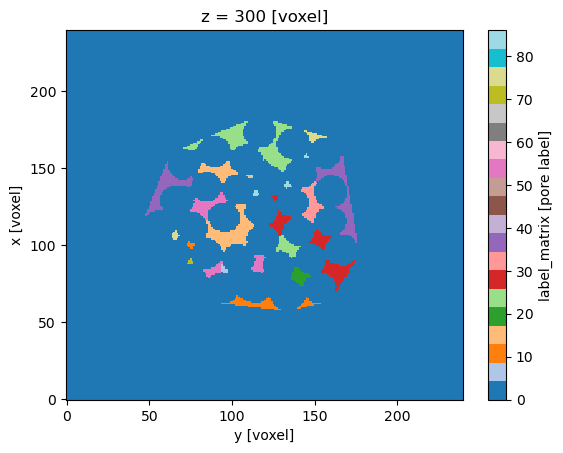

In [28]:
data['label_matrix'].sel(z=300).plot(cmap='tab20')